In [71]:
from rdflib import Graph, URIRef
import numpy as np
import glob 

import tqdm.notebook as tq

ONLY_ORGANIC = True
TRAINING = True
folds = 7

chemical_graph = Graph()
for filename in glob.glob('only_organic_reduced_kgs/reduced_chembl*' if ONLY_ORGANIC else 'reduced_kgs/reduced_chembl*'):
    chemical_graph.load(filename,format=filename.split('.')[-1])
chemical_graph.load('only_organic_reduced_kgs/reduced_chebi.ttl' if ONLY_ORGANIC else 'reduced_kgs/reduced_chebi.ttl',format='ttl')
#chemical_graph.load('only_organic_reduced_kgs/reduced_mesh.nt' if ONLY_ORGANIC else 'reduced_kgs/reduced_mesh.nt',format='nt')
 
species_graph = Graph()
species_graph.load('only_organic_reduced_kgs/reduced_taxonomy.nt' if ONLY_ORGANIC else 'reduced_kgs/reduced_taxonomy.nt',format='nt')
species_graph.load('only_organic_reduced_kgs/reduced_traits.nt' if ONLY_ORGANIC else 'reduced_kgs/reduced_traits.nt',format='nt')

chemical_entities = sorted(list(set(chemical_graph.subjects()) | set(chemical_graph.objects())))
chemical_relations = sorted(list(set(chemical_graph.predicates())))
print(len(chemical_entities), len(chemical_relations), len(chemical_graph))

species_entities = sorted(list(set(species_graph.subjects()) | set(species_graph.objects())))
species_relations = sorted(list(set(species_graph.predicates())))
print(len(species_entities), len(species_relations), len(species_graph))

16655 20 43133
2149 55 9982


In [72]:
import pandas as pd

effect_data = pd.read_csv('only_organic_effect_data_extra.csv' if ONLY_ORGANIC else 'effect_data_extra.csv')
effect_data = effect_data[effect_data['species'].isin(set(map(str,species_entities)))]
effect_data = effect_data[effect_data['chemical'].isin(set(map(str,chemical_entities)))]

In [73]:
effect_data.species_divisions.unique()

array(['https://cfpub.epa.gov/ecotox/group/Fish',
       'https://cfpub.epa.gov/ecotox/group/Crustaceans',
       'https://cfpub.epa.gov/ecotox/group/Insects/Spiders',
       'https://cfpub.epa.gov/ecotox/group/Amphibians',
       'https://cfpub.epa.gov/ecotox/group/Worms',
       'https://cfpub.epa.gov/ecotox/group/Invertebrates',
       'https://cfpub.epa.gov/ecotox/group/Molluscs'], dtype=object)

In [74]:

import random
import tensorflow as tf

def set_all_seeds(seed):

    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

In [75]:

from time import sleep
from rdflib.namespace import Namespace
schema = Namespace('https://schema.org/')

import sys
from SPARQLWrapper import SPARQLWrapper, JSON
from pubchempy import Compound

endpoint_url = "https://query.wikidata.org/sparql"

query = """select ?cas ?pc where {
  ?c wdt:P231 ?tmp ;
     wdt:P662 ?pc .
  bind(replace(?tmp,'-','') as ?cas)
}"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


extra_graph = Graph()

try:
    extra_graph.load('only_organic_physical_properties.ttl' if ONLY_ORGANIC else 'physical_properties.ttl',format='ttl')

except FileNotFoundError:

    results = get_results(endpoint_url, query)
    for result in tq.tqdm(results["results"]["bindings"]):
        chem_id = 'https://cfpub.epa.gov/ecotox/cas/'+result['cas']['value']
        if not chem_id in ent:
            continue
        vioxx = Compound.from_cid(int(result['pc']['value']))
        mm = vioxx.molecular_weight
        logp = vioxx.xlogp

        if mm:

            if mm < 600:
                extra_graph.add((URIRef(chem_id),URIRef('http://example.org/compoundIsHeavy'),schema['False']))
            else:
                extra_graph.add((URIRef(chem_id),URIRef('http://example.org/compoundIsHeavy'),schema['True']))

        if logp:
            if logp < 4:
                extra_graph.add((URIRef(chem_id),URIRef('http://example.org/compoundLogPCategory'),URIRef('http://example.org/low')))
            elif logp < 5.5:
                extra_graph.add((URIRef(chem_id),URIRef('http://example.org/compoundLogPCategory'),URIRef('http://example.org/medium')))
            else:
                extra_graph.add((URIRef(chem_id),URIRef('http://example.org/compoundLogPCategory'),URIRef('http://example.org/high')))

    extra_graph.serialize('only_organic_physical_properties.ttl' if ONLY_ORGANIC else 'physical_properties.ttl',format='ttl')

chemical_graph += extra_graph
                

In [76]:
chemical_entities = sorted(list(set(chemical_graph.subjects()) | set(chemical_graph.objects())))
chemical_relations = sorted(list(set(chemical_graph.predicates())))
print(len(chemical_entities), len(chemical_relations), len(chemical_graph))

16807 22 46432


In [77]:
chemical_entity_mappings = {e:i for i,e in enumerate(chemical_entities)}
chemical_relation_mappings = {e:i for i,e in enumerate(chemical_relations)}
chemical_triples = np.asarray(list(map(lambda x: (chemical_entity_mappings[x[0]],
                                         chemical_relation_mappings[x[1]],
                                         chemical_entity_mappings[x[2]]),chemical_graph)))
species_entity_mappings = {e:i for i,e in enumerate(species_entities)}
species_relation_mappings = {e:i for i,e in enumerate(species_relations)}
species_triples = np.asarray(list(map(lambda x: (species_entity_mappings[x[0]],
                                         species_relation_mappings[x[1]],
                                         species_entity_mappings[x[2]]),species_graph)))


In [78]:
import tensorflow as tf
from embedding_model import DistMult, ComplEx, TransE, ConvE

In [79]:

def create_negative(positive,entities, n=2):
    negative = np.repeat(positive,n,axis=0)
    negative[:,0] = np.random.randint(0,len(entities),size=len(positive)*n)
    negative[:,2] = np.random.randint(0,len(entities),size=len(positive)*n)
    return negative

In [80]:
def train_generator(t,e,batch_size=32,n=2):
    
    t = t[np.random.randint(0,len(t),size=len(t))]
    
    num_batches = len(t)//batch_size
    
    for i in range(num_batches):
        
        positive = t[i*batch_size:i*batch_size+batch_size]
        negative = create_negative(positive,e,n)
        X = np.concatenate([positive,negative],axis=0)
        y = np.concatenate([np.ones(len(positive)),-1*np.ones(len(negative))],axis=0)
        
        yield (X,y),y
        

In [81]:

total_models = 4
total_dim = 400
bs = 512
EPOCHS = 100

for j,(triples,e,r) in enumerate(zip([chemical_triples,species_triples],
                             [chemical_entities,species_entities],
                             [chemical_relations,species_relations])):

    if TRAINING:

        embeddings = []

        for n in tq.tqdm(range(total_models)):

            embedding_model = ComplEx(e,r,dim=total_dim//total_models,mdl=0.0)

            best_loss = float('inf')
            losses = []
            patience=10

            for i in tq.tqdm(range(EPOCHS),leave=False):

                hist = embedding_model.fit(train_generator(triples,e,batch_size=bs,n=32),
                                 steps_per_epoch=len(triples)//bs,
                                 verbose=0)

                l = hist.history['loss'][-1]
                losses.append(l)
                if l < best_loss:
                    best_loss = l
                    c = 0
                else:
                    c += 1

                if c > patience: break

            embeddings.append(embedding_model.get_layer('entity_embedding').get_weights()[0])

        if len(embeddings)>1:
            W = np.concatenate(embeddings,axis=1)
        else:
            W = embeddings[-1]

        np.save(f'organic_only_W_{j}.npy' if ONLY_ORGANIC else f'W_{j}.npy',W)

W = [np.load(f'organic_only_W_{i}.npy' if ONLY_ORGANIC else f'W_{i}.npy') for i in range(2)]


In [82]:
fps = {}

import sys
from SPARQLWrapper import SPARQLWrapper, JSON
from pubchempy import Compound

endpoint_url = "https://query.wikidata.org/sparql"

query = """select ?cas ?pc where {
  ?c wdt:P231 ?tmp ;
     wdt:P662 ?pc .
  bind(replace(?tmp,'-','') as ?cas)
}"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

try: 
    fps = pd.read_pickle('fingerprints.pkl')

except FileNotFoundError:
    
    results = get_results(endpoint_url, query)
    for result in tq.tqdm(results["results"]["bindings"]):
        chem_id = 'https://cfpub.epa.gov/ecotox/cas/'+result['cas']['value']
        if chem_id in set(effect_data.chemical.values): 
            vioxx = Compound.from_cid(int(result['pc']['value']))
            fps[chem_id] = vioxx.fingerprint
    pd.to_pickle(fps,'fingerprints.pkl')


In [83]:
def to_bin(he): 
    scale = 16 ## equals to hexadecimal
    num_of_bits = 900
    return bin(int(he, scale))[2:].zfill(num_of_bits)

effect_data['fp'] = [to_bin(fps[c]) if c in fps else to_bin('0') for c in effect_data['chemical'].values]


In [84]:
def tanimoto(a,b):
    return sum(np.where(a==b,1,0))/sum(np.where(a-b>0,1,0)+np.where(b-a>0,1,0)+np.where(a==b,1,0))
    

In [85]:
%time
from itertools import product

M = np.zeros(len(np.unique(effect_data['fp']))**2)
F = []

for i,(a,b) in tq.tqdm(enumerate(product(np.unique(effect_data['fp']),np.unique(effect_data['fp']))),total=len(np.unique(effect_data['fp']))**2):
    a,b=np.asarray([int(i) for i in a]),np.asarray([int(i) for i in b])
    M[i] += tanimoto(a,b)

for a in np.unique(effect_data['fp']):
    a=np.asarray([int(i) for i in a])
    F.append(a)
    
M = M.reshape((len(np.unique(effect_data['fp'])),len(np.unique(effect_data['fp']))))
D = 1-M
F = np.asarray(F)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [86]:
from sklearn.cluster import AgglomerativeClustering
c = AgglomerativeClustering(n_clusters=7,affinity='precomputed',linkage='complete')
clusters = c.fit_predict(D)
idxs = {e:i for i,e in enumerate(np.unique(effect_data['fp']))}

effect_data['fp_sim_cluster'] = [clusters[idxs[e]] for e in effect_data['fp']]
u,c = np.unique(clusters,return_counts=True)

In [87]:
for i in np.where(c<10)[0]: #less than 10 chemicals
    effect_data.drop(effect_data[effect_data['fp_sim_cluster'] == u[i]].index,inplace=True)

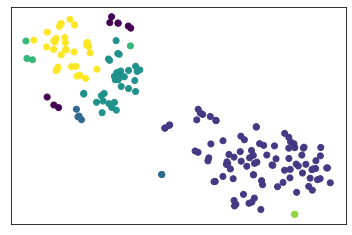

In [88]:
from sklearn.manifold import TSNE
pca = TSNE(2,random_state=42)

X = pca.fit_transform(F).T

import matplotlib.pyplot as plt
plt.scatter(*X,c=clusters)
plt.xticks([], [])
plt.yticks([], [])
plt.savefig('only_organic_clusters.png' if ONLY_ORGANIC else 'clusters.png')

In [89]:
def custom_loss(true,pred):
    return tf.reduce_mean(tf.where(true-pred>1,abs(true-pred),(true-pred)**2))

In [90]:
for c in effect_data['chemical'].unique():
    assert len(set(effect_data.loc[effect_data['chemical']==c,'fp_sim_cluster'].values)) < 2

In [91]:
effect_data['chemical'] = [chemical_entity_mappings[URIRef(x)] for x in effect_data['chemical']]
effect_data['species'] = [species_entity_mappings[URIRef(x)] for x in effect_data['species']]
data = effect_data[['chemical','species','log conc (mol/L)']].values

pd.to_pickle(chemical_entity_mappings,'only_organic_chemical_entity_mappings.pkl' if ONLY_ORGANIC else 'chemical_entity_mappings.pkl')
pd.to_pickle(species_entity_mappings,'only_organic_species_entity_mappings.pkl' if ONLY_ORGANIC else 'species_entity_mappings.pkl')

In [92]:
import xgboost as xgb

In [93]:
def weighted_metric(values,groups):
    _,c = np.unique(groups,return_counts=True)
    c = c/sum(c)
    return np.nansum(c*values,axis=1)/sum(np.where(values!=np.nan,1,0))

In [95]:

chemical_mapping = {int(k):i for i,k in enumerate(set(data[:,0]))}
species_mapping = {int(k):i for i,k in enumerate(set(data[:,1]))}

W1 = np.random.uniform(-1,1,size=(len(chemical_mapping),total_dim))
W2 = np.random.uniform(-1,1,size=(len(species_mapping),total_dim))

def data_generator(X,Y,use_embedding=False):
        
    if use_embedding:
        x = np.asarray(list(map(lambda x:np.concatenate([W[0][x[0]],W[1][x[1]]],axis=0),X)))
    else:
        v1 = np.zeros((len(X),len(chemical_mapping)))
        v2 = np.zeros((len(X),len(species_mapping)))
        for j,(a,b) in enumerate(X):
            v1[j,chemical_mapping[a]] = 1.0
            v2[j,species_mapping[b]] = 1.0
        v1 = v1 @ W1
        v2 = v2 @ W2
        x = np.concatenate([v1,v2],axis=1)
    
    return x,Y

In [96]:
from collections import defaultdict

def split_group(g,k,shuffle = False):
    g = np.asarray(list(g))
    return np.array_split(np.random.permutation(g) if shuffle else g,k,axis=0)

def mysplits(groups,subgroups,k=5):
    
    group_entities = defaultdict(set)
    for g,s in zip(groups,subgroups):
        group_entities[g].add(s)

    all_train = []
    all_test = []
    
    gs = {g:split_group(group_entities[g],k,shuffle=True) for g in group_entities}
    
    for i in range(k):
        all_train = np.concatenate([np.concatenate([gs[g][j] for g in gs]) for j in range(k) if j != i])
        all_test = np.concatenate([gs[g][i] for g in gs])
        
        assert len(np.intersect1d(all_train,all_test)) < 1 #train and test entities, eg. chemicals
        
        train_indices = np.concatenate([np.where(subgroups==ts)[0] for ts in all_train],axis=0)
        test_indices = np.concatenate([np.where(subgroups==ts)[0] for ts in all_test],axis=0)
    
        assert len(np.intersect1d(train_indices,test_indices)) < 1
    
        yield train_indices,test_indices


In [97]:
split_function = lambda g,c: mysplits(g, c, folds)
for train,test in split_function(effect_data['fp_sim_cluster'].values,effect_data['chemical'].values):
    print(len(train),len(test))
    print(np.intersect1d(effect_data['chemical'].values[test],effect_data['chemical'].values[train]).shape)

    
print('')
for train,test in split_function(effect_data['species_divisions'].values,effect_data['species'].values):
    print(len(train),len(test))
    print(np.intersect1d(effect_data['species'].values[test],effect_data['species'].values[train]).shape)


605 80
(0,)
494 191
(0,)
570 115
(0,)
610 75
(0,)
625 60
(0,)
581 104
(0,)
625 60
(0,)

595 90
(0,)
598 87
(0,)
568 117
(0,)
612 73
(0,)
618 67
(0,)
494 191
(0,)
625 60
(0,)


In [98]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model_fn = lambda params : Pipeline([('svr',SVR(**params))])

In [99]:
from sklearn.metrics import r2_score
y = data[:,-1].astype('float32')
X = data[:,:-1].astype(int)

def one_search(X,y,folds,params={},use_embeddings=False):
    
    oof = np.zeros(y.shape)
    for train,test in folds: 
        model = model_fn(params) 
        model.fit(*data_generator(X[train],y[train]))
        
        oof[test] += model.predict(data_generator(X[test],y[test])[0]).ravel()
        
    return r2_score(y,oof)

all_params = []
for c in 10.**np.arange(-4,5):
    for g in 10.**np.arange(-4,5):
        all_params.append({'C':c,'gamma':g})

split_function = lambda g,c: mysplits(g, c, folds)

bsp = []

for f in [lambda : split_function(effect_data['fp_sim_cluster'].values,effect_data['chemical'].values),
         lambda : split_function(effect_data['species_divisions'].values,effect_data['species'].values)]:
    bp = []
    for use_embeddings in [True,False]:

        N = 100
        best_r2 = -float('inf')
        for params in tq.tqdm(all_params):

            r2 = one_search(X,y,f(),params,use_embeddings=use_embeddings)
            if r2 > best_r2:
                best_r2 = r2
                best_params = params

        print(best_r2,best_params)
        bp.append(best_params)
    bsp.append(bp)


0.020022368640476018 {'C': 1000.0, 'gamma': 0.01}



0.017384286325227483 {'C': 10.0, 'gamma': 0.01}



0.25877789326879996 {'C': 10.0, 'gamma': 0.0001}



0.26431393241336 {'C': 10.0, 'gamma': 0.001}


In [100]:
%%time
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import random

y = data[:,-1].astype('float32')
X = data[:,:-1].astype(int)

EPOCHS = 1000


N = 100
def product_int(a,b):
    
    for m,n in product(a,b):
        train1,test1 = m
        train2,test2 = n
        
        yield np.intersect1d(train1,train2),np.intersect1d(test1,test2)

params = {}
    
for i, (fold_function, name, params) in enumerate(zip([lambda : split_function(effect_data['fp_sim_cluster'].values,
                                                        effect_data['chemical'].values),
                               lambda : split_function(effect_data['species_divisions'].values,
                                                      effect_data['species'].values),
                                #lambda : product_int(split_function(effect_data['fp_sim_cluster'].values,
                                #                                   effect_data['chemical'].values),
                                #                split_function(effect_data['species_divisions'].values,
                                #                              effect_data['species'].values))
                               ],
                               ['equal_prop_fp_sim_cluster',
                                'equal_prop_species_division',
                                #'equal_prop_fp_sim_cluster_x_equal_prop_species_division'
                                 ],bsp)):

    scores = []
    per_fold_scores = []
    
    oof = np.zeros(y.shape)
    oof_embedding = np.zeros(y.shape)

    for seed in tq.tqdm(range(N)):
        
        oof_this_seed = np.zeros(y.shape)
        oof_this_seed_embedding = np.zeros(y.shape)

        for j,(train,test) in tq.tqdm(enumerate(fold_function()),
                                      total=folds,
                                      desc='Folds',
                                      leave=False):
            
            model = model_fn(params[0])
            model.fit(*data_generator(X[train],y[train]))
            
            p1 = model.predict(data_generator(X[test],y[test])[0]).ravel()
            oof[test] += p1/N
            oof_this_seed[test] += p1

            model = model_fn(params[1])
            model.fit(*data_generator(X[train],y[train],use_embedding=True))
            
            p2 = model.predict(data_generator(X[test],y[test],use_embedding=True)[0]).ravel()
            oof_embedding[test] += p2/N
            oof_this_seed_embedding[test] += p2

            per_fold_scores.append([r2_score(y[test],p1),r2_score(y[test],p2)])
            
        s,s_embedding = np.split(np.asarray(per_fold_scores),2,axis=1)
        print(name,'Out-of-fold R^2',
          round(np.nanmean(s),4),'+-',round(np.nanstd(s),4),
          'Embedding:',round(np.nanmean(s_embedding),4),'+-',round(np.nanstd(s_embedding),4))
        
        scores.append([r2_score(y,oof_this_seed),r2_score(y,oof_this_seed_embedding)])

        pd.DataFrame(data=dict(species=effect_data.species,chemical=effect_data.chemical,prediction=oof_this_seed,true=y)).to_csv(f'results/{name}_seed_{seed}_only_organic_predictions.csv' if ONLY_ORGANIC else f'results/{name}_seed_{seed}_predictions.csv')
        pd.DataFrame(data=dict(species=effect_data.species,chemical=effect_data.chemical,prediction=oof_this_seed_embedding,true=y)).to_csv(f'results/{name}_seed_{seed}_only_organic_predictions_embedding.csv' if ONLY_ORGANIC else f'results/{name}_seed_{seed}_predictions_embedding.csv')

    pd.DataFrame(data=dict(species=effect_data.species,chemical=effect_data.chemical,prediction=oof,true=y)).to_csv(f'results/{name}_only_organic_predictions.csv' if ONLY_ORGANIC else f'results/{name}_predictions.csv')
    pd.DataFrame(data=dict(species=effect_data.species,chemical=effect_data.chemical,prediction=oof_embedding,true=y)).to_csv(f'results/{name}_only_organic_predictions_embedding.csv' if ONLY_ORGANIC else f'results/{name}_predictions_embedding.csv')
    

equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0233 +- 0.0719 Embedding: -0.0258 +- 0.1459


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0288 +- 0.0847 Embedding: -0.0257 +- 0.1527


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0559 +- 0.0925 Embedding: -0.0275 +- 0.1313


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0574 +- 0.0903 Embedding: -0.038 +- 0.1221


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0554 +- 0.0837 Embedding: -0.041 +- 0.1153


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0482 +- 0.0808 Embedding: -0.04 +- 0.1247


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0504 +- 0.0899 Embedding: -0.0393 +- 0.1362


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.043 +- 0.0875 Embedding: -0.0432 +- 0.1451


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0413 +- 0.0842 Embedding: -0.0456 +- 0.1422


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0387 +- 0.0821 Embedding: -0.0434 +- 0.1435


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0391 +- 0.0805 Embedding: -0.0433 +- 0.1443


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0417 +- 0.0808 Embedding: -0.0402 +- 0.1427


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0416 +- 0.0787 Embedding: -0.0364 +- 0.1428


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0414 +- 0.0797 Embedding: -0.0329 +- 0.1428


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0427 +- 0.0829 Embedding: -0.033 +- 0.1423


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0454 +- 0.0956 Embedding: -0.0364 +- 0.1549


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0505 +- 0.0994 Embedding: -0.0412 +- 0.1537


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.05 +- 0.0981 Embedding: -0.0407 +- 0.1523


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0532 +- 0.1021 Embedding: -0.0428 +- 0.1515


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0565 +- 0.1065 Embedding: -0.0473 +- 0.1525


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0551 +- 0.1048 Embedding: -0.0462 +- 0.1536


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0583 +- 0.1079 Embedding: -0.0509 +- 0.1555


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0558 +- 0.1065 Embedding: -0.0506 +- 0.1557


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0577 +- 0.1063 Embedding: -0.0502 +- 0.1537


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0576 +- 0.1049 Embedding: -0.0505 +- 0.1539


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0561 +- 0.1038 Embedding: -0.0486 +- 0.1533


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0569 +- 0.1038 Embedding: -0.0476 +- 0.1524


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0652 +- 0.1366 Embedding: -0.0545 +- 0.1606


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0668 +- 0.1419 Embedding: -0.0579 +- 0.1668


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0646 +- 0.1404 Embedding: -0.0553 +- 0.166


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0635 +- 0.1391 Embedding: -0.0556 +- 0.1665


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.063 +- 0.1375 Embedding: -0.0551 +- 0.1657


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0635 +- 0.1364 Embedding: -0.0564 +- 0.1653


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0626 +- 0.1353 Embedding: -0.0547 +- 0.1653


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0615 +- 0.134 Embedding: -0.0545 +- 0.1684


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0616 +- 0.1329 Embedding: -0.0554 +- 0.1676


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0614 +- 0.1322 Embedding: -0.0579 +- 0.1709


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0607 +- 0.131 Embedding: -0.0581 +- 0.1697


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0632 +- 0.142 Embedding: -0.0613 +- 0.1812


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0625 +- 0.1411 Embedding: -0.0628 +- 0.1807


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0629 +- 0.14 Embedding: -0.0644 +- 0.1812


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0662 +- 0.1504 Embedding: -0.0673 +- 0.1869


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0671 +- 0.1494 Embedding: -0.068 +- 0.1851


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0662 +- 0.1481 Embedding: -0.0673 +- 0.1845


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0661 +- 0.148 Embedding: -0.0664 +- 0.1846


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0665 +- 0.1478 Embedding: -0.0654 +- 0.1843


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0662 +- 0.1471 Embedding: -0.0642 +- 0.1846


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0649 +- 0.1463 Embedding: -0.063 +- 0.1831


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0644 +- 0.1453 Embedding: -0.0627 +- 0.1826


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0638 +- 0.144 Embedding: -0.062 +- 0.1817


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0639 +- 0.1438 Embedding: -0.0621 +- 0.1815


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0646 +- 0.1432 Embedding: -0.0623 +- 0.1816


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0642 +- 0.1425 Embedding: -0.0623 +- 0.1809


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0639 +- 0.1417 Embedding: -0.0631 +- 0.1806


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0643 +- 0.143 Embedding: -0.0629 +- 0.1821


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0633 +- 0.1422 Embedding: -0.0618 +- 0.1817


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0625 +- 0.1411 Embedding: -0.0604 +- 0.1814


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0622 +- 0.1408 Embedding: -0.0601 +- 0.1819


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0625 +- 0.1406 Embedding: -0.0618 +- 0.1815


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0624 +- 0.1407 Embedding: -0.0621 +- 0.182


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0627 +- 0.1405 Embedding: -0.0622 +- 0.1822


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0622 +- 0.1397 Embedding: -0.0611 +- 0.1816


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.063 +- 0.1429 Embedding: -0.0632 +- 0.1883


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0624 +- 0.1422 Embedding: -0.0632 +- 0.1879


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0618 +- 0.1416 Embedding: -0.0628 +- 0.187


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0629 +- 0.1425 Embedding: -0.0634 +- 0.1873


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0634 +- 0.1424 Embedding: -0.0633 +- 0.187


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0634 +- 0.1418 Embedding: -0.0635 +- 0.1863


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0632 +- 0.1408 Embedding: -0.0638 +- 0.1868


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0632 +- 0.1401 Embedding: -0.0633 +- 0.1865


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.063 +- 0.1397 Embedding: -0.063 +- 0.1857


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.064 +- 0.1395 Embedding: -0.0643 +- 0.1855


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0642 +- 0.1389 Embedding: -0.0649 +- 0.1854


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.064 +- 0.1381 Embedding: -0.0654 +- 0.1847


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.064 +- 0.1377 Embedding: -0.066 +- 0.1846


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0631 +- 0.1371 Embedding: -0.0649 +- 0.1842


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0626 +- 0.1364 Embedding: -0.0643 +- 0.1835


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0617 +- 0.1358 Embedding: -0.0632 +- 0.1831


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0608 +- 0.1353 Embedding: -0.0623 +- 0.1826


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0609 +- 0.1353 Embedding: -0.0622 +- 0.1826


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.061 +- 0.135 Embedding: -0.0618 +- 0.1824


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0611 +- 0.1345 Embedding: -0.0618 +- 0.1826


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0612 +- 0.1343 Embedding: -0.0627 +- 0.1826


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0617 +- 0.1341 Embedding: -0.0631 +- 0.1826


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0615 +- 0.1336 Embedding: -0.0632 +- 0.1821


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.061 +- 0.133 Embedding: -0.0625 +- 0.1817


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0611 +- 0.1329 Embedding: -0.0631 +- 0.183


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0611 +- 0.1326 Embedding: -0.0631 +- 0.1831


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0611 +- 0.1323 Embedding: -0.0623 +- 0.1825


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0615 +- 0.1319 Embedding: -0.0626 +- 0.1826


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0621 +- 0.1318 Embedding: -0.0627 +- 0.1826


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0626 +- 0.1325 Embedding: -0.0628 +- 0.1819


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0632 +- 0.1332 Embedding: -0.0631 +- 0.182


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0628 +- 0.1328 Embedding: -0.062 +- 0.1817


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0636 +- 0.133 Embedding: -0.0632 +- 0.182


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0631 +- 0.1325 Embedding: -0.0629 +- 0.1817


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0633 +- 0.1335 Embedding: -0.0626 +- 0.1817


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0636 +- 0.1333 Embedding: -0.0632 +- 0.1824


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0631 +- 0.1328 Embedding: -0.0631 +- 0.1819


equal_prop_fp_sim_cluster Out-of-fold R^2 -0.0631 +- 0.1324 Embedding: -0.0632 +- 0.1815



equal_prop_species_division Out-of-fold R^2 0.262 +- 0.0466 Embedding: 0.3561 +- 0.0582


equal_prop_species_division Out-of-fold R^2 0.2419 +- 0.1174 Embedding: 0.3428 +- 0.094


equal_prop_species_division Out-of-fold R^2 0.2333 +- 0.1188 Embedding: 0.3337 +- 0.0987


equal_prop_species_division Out-of-fold R^2 0.2355 +- 0.1094 Embedding: 0.3375 +- 0.0998


equal_prop_species_division Out-of-fold R^2 0.24 +- 0.1083 Embedding: 0.3395 +- 0.1122


equal_prop_species_division Out-of-fold R^2 0.239 +- 0.1087 Embedding: 0.3367 +- 0.1142


equal_prop_species_division Out-of-fold R^2 0.2397 +- 0.1063 Embedding: 0.3394 +- 0.1128


equal_prop_species_division Out-of-fold R^2 0.2376 +- 0.1052 Embedding: 0.3382 +- 0.1134


equal_prop_species_division Out-of-fold R^2 0.2402 +- 0.1045 Embedding: 0.3391 +- 0.1153


equal_prop_species_division Out-of-fold R^2 0.2412 +- 0.1025 Embedding: 0.338 +- 0.1134


equal_prop_species_division Out-of-fold R^2 0.242 +- 0.0998 Embedding: 0.3386 +- 0.1117


equal_prop_species_division Out-of-fold R^2 0.242 +- 0.1022 Embedding: 0.3373 +- 0.1117


equal_prop_species_division Out-of-fold R^2 0.2437 +- 0.1016 Embedding: 0.3383 +- 0.1119


equal_prop_species_division Out-of-fold R^2 0.245 +- 0.1 Embedding: 0.3394 +- 0.1109


equal_prop_species_division Out-of-fold R^2 0.2434 +- 0.1062 Embedding: 0.3388 +- 0.1153


equal_prop_species_division Out-of-fold R^2 0.2444 +- 0.1082 Embedding: 0.3405 +- 0.1178


equal_prop_species_division Out-of-fold R^2 0.2431 +- 0.1089 Embedding: 0.3387 +- 0.1185


equal_prop_species_division Out-of-fold R^2 0.2437 +- 0.1088 Embedding: 0.3376 +- 0.1187


equal_prop_species_division Out-of-fold R^2 0.2432 +- 0.1081 Embedding: 0.3361 +- 0.1174


equal_prop_species_division Out-of-fold R^2 0.2428 +- 0.1082 Embedding: 0.3371 +- 0.1162


equal_prop_species_division Out-of-fold R^2 0.2421 +- 0.1075 Embedding: 0.3355 +- 0.1148


equal_prop_species_division Out-of-fold R^2 0.243 +- 0.1078 Embedding: 0.3359 +- 0.1178


equal_prop_species_division Out-of-fold R^2 0.2417 +- 0.1093 Embedding: 0.3337 +- 0.1187


equal_prop_species_division Out-of-fold R^2 0.242 +- 0.1108 Embedding: 0.333 +- 0.1188


equal_prop_species_division Out-of-fold R^2 0.2422 +- 0.1113 Embedding: 0.333 +- 0.1209


equal_prop_species_division Out-of-fold R^2 0.2423 +- 0.1119 Embedding: 0.3329 +- 0.1213


equal_prop_species_division Out-of-fold R^2 0.2426 +- 0.1117 Embedding: 0.3329 +- 0.1211


equal_prop_species_division Out-of-fold R^2 0.2411 +- 0.1113 Embedding: 0.3312 +- 0.1201


equal_prop_species_division Out-of-fold R^2 0.2417 +- 0.1105 Embedding: 0.331 +- 0.1194


equal_prop_species_division Out-of-fold R^2 0.2412 +- 0.1114 Embedding: 0.3301 +- 0.12


equal_prop_species_division Out-of-fold R^2 0.2404 +- 0.1134 Embedding: 0.3292 +- 0.1202


equal_prop_species_division Out-of-fold R^2 0.2392 +- 0.1178 Embedding: 0.3286 +- 0.1225


equal_prop_species_division Out-of-fold R^2 0.2395 +- 0.1174 Embedding: 0.3293 +- 0.1222


equal_prop_species_division Out-of-fold R^2 0.2396 +- 0.1168 Embedding: 0.3293 +- 0.1218


equal_prop_species_division Out-of-fold R^2 0.2395 +- 0.1186 Embedding: 0.3285 +- 0.1229


equal_prop_species_division Out-of-fold R^2 0.2399 +- 0.1181 Embedding: 0.3282 +- 0.1227


equal_prop_species_division Out-of-fold R^2 0.2392 +- 0.1179 Embedding: 0.3278 +- 0.124


equal_prop_species_division Out-of-fold R^2 0.2387 +- 0.1173 Embedding: 0.3277 +- 0.1232


equal_prop_species_division Out-of-fold R^2 0.2385 +- 0.1169 Embedding: 0.3273 +- 0.1251


equal_prop_species_division Out-of-fold R^2 0.2385 +- 0.1183 Embedding: 0.3276 +- 0.126


equal_prop_species_division Out-of-fold R^2 0.2379 +- 0.1173 Embedding: 0.3268 +- 0.1257


equal_prop_species_division Out-of-fold R^2 0.2382 +- 0.117 Embedding: 0.3272 +- 0.1251


equal_prop_species_division Out-of-fold R^2 0.2387 +- 0.1161 Embedding: 0.3277 +- 0.1238


equal_prop_species_division Out-of-fold R^2 0.2386 +- 0.1159 Embedding: 0.3278 +- 0.1243


equal_prop_species_division Out-of-fold R^2 0.2394 +- 0.1157 Embedding: 0.3291 +- 0.1247


equal_prop_species_division Out-of-fold R^2 0.2397 +- 0.117 Embedding: 0.3295 +- 0.1256


equal_prop_species_division Out-of-fold R^2 0.2398 +- 0.1173 Embedding: 0.3299 +- 0.1255


equal_prop_species_division Out-of-fold R^2 0.2401 +- 0.1164 Embedding: 0.3301 +- 0.1244


equal_prop_species_division Out-of-fold R^2 0.24 +- 0.1163 Embedding: 0.3297 +- 0.1253


equal_prop_species_division Out-of-fold R^2 0.2402 +- 0.1161 Embedding: 0.3295 +- 0.1261


equal_prop_species_division Out-of-fold R^2 0.2408 +- 0.1159 Embedding: 0.3299 +- 0.1265


equal_prop_species_division Out-of-fold R^2 0.2404 +- 0.1163 Embedding: 0.3301 +- 0.1269


equal_prop_species_division Out-of-fold R^2 0.24 +- 0.117 Embedding: 0.33 +- 0.1275


equal_prop_species_division Out-of-fold R^2 0.2397 +- 0.1169 Embedding: 0.3301 +- 0.1273


equal_prop_species_division Out-of-fold R^2 0.2394 +- 0.1179 Embedding: 0.33 +- 0.1277


equal_prop_species_division Out-of-fold R^2 0.2395 +- 0.1175 Embedding: 0.3302 +- 0.1272


equal_prop_species_division Out-of-fold R^2 0.2398 +- 0.1167 Embedding: 0.3304 +- 0.1264


equal_prop_species_division Out-of-fold R^2 0.2397 +- 0.1168 Embedding: 0.3305 +- 0.1264


equal_prop_species_division Out-of-fold R^2 0.2395 +- 0.1166 Embedding: 0.3303 +- 0.1262


equal_prop_species_division Out-of-fold R^2 0.24 +- 0.1162 Embedding: 0.3307 +- 0.1263


equal_prop_species_division Out-of-fold R^2 0.2398 +- 0.1164 Embedding: 0.3305 +- 0.127


equal_prop_species_division Out-of-fold R^2 0.2398 +- 0.116 Embedding: 0.3303 +- 0.1267


equal_prop_species_division Out-of-fold R^2 0.2399 +- 0.1158 Embedding: 0.3308 +- 0.1265


equal_prop_species_division Out-of-fold R^2 0.2392 +- 0.1162 Embedding: 0.3303 +- 0.1264


equal_prop_species_division Out-of-fold R^2 0.2396 +- 0.1157 Embedding: 0.3306 +- 0.1262


equal_prop_species_division Out-of-fold R^2 0.2397 +- 0.1156 Embedding: 0.3306 +- 0.126


equal_prop_species_division Out-of-fold R^2 0.24 +- 0.1153 Embedding: 0.3307 +- 0.1257


equal_prop_species_division Out-of-fold R^2 0.2399 +- 0.1148 Embedding: 0.3307 +- 0.1254


equal_prop_species_division Out-of-fold R^2 0.2405 +- 0.1149 Embedding: 0.3312 +- 0.1259


equal_prop_species_division Out-of-fold R^2 0.2407 +- 0.1143 Embedding: 0.3316 +- 0.1252


equal_prop_species_division Out-of-fold R^2 0.2401 +- 0.1153 Embedding: 0.3307 +- 0.1255


equal_prop_species_division Out-of-fold R^2 0.2399 +- 0.1152 Embedding: 0.3302 +- 0.1265


equal_prop_species_division Out-of-fold R^2 0.2398 +- 0.1159 Embedding: 0.3301 +- 0.1264


equal_prop_species_division Out-of-fold R^2 0.2394 +- 0.116 Embedding: 0.3299 +- 0.1262


equal_prop_species_division Out-of-fold R^2 0.2396 +- 0.1156 Embedding: 0.33 +- 0.126


equal_prop_species_division Out-of-fold R^2 0.2396 +- 0.1157 Embedding: 0.3302 +- 0.1257


equal_prop_species_division Out-of-fold R^2 0.2393 +- 0.1157 Embedding: 0.33 +- 0.1254


equal_prop_species_division Out-of-fold R^2 0.2396 +- 0.1158 Embedding: 0.3302 +- 0.1253


equal_prop_species_division Out-of-fold R^2 0.2398 +- 0.1157 Embedding: 0.3303 +- 0.125


equal_prop_species_division Out-of-fold R^2 0.2393 +- 0.1162 Embedding: 0.3299 +- 0.1254


equal_prop_species_division Out-of-fold R^2 0.2391 +- 0.1159 Embedding: 0.3297 +- 0.1251


equal_prop_species_division Out-of-fold R^2 0.2393 +- 0.1167 Embedding: 0.3297 +- 0.1262


equal_prop_species_division Out-of-fold R^2 0.2393 +- 0.117 Embedding: 0.3297 +- 0.1265


equal_prop_species_division Out-of-fold R^2 0.2391 +- 0.1168 Embedding: 0.3297 +- 0.1261


equal_prop_species_division Out-of-fold R^2 0.239 +- 0.1166 Embedding: 0.3298 +- 0.1257


equal_prop_species_division Out-of-fold R^2 0.2389 +- 0.1164 Embedding: 0.3298 +- 0.1253


equal_prop_species_division Out-of-fold R^2 0.2389 +- 0.1161 Embedding: 0.3296 +- 0.1251


equal_prop_species_division Out-of-fold R^2 0.2384 +- 0.116 Embedding: 0.3292 +- 0.1255


equal_prop_species_division Out-of-fold R^2 0.2385 +- 0.1159 Embedding: 0.329 +- 0.1255


equal_prop_species_division Out-of-fold R^2 0.2383 +- 0.1156 Embedding: 0.3289 +- 0.1254


equal_prop_species_division Out-of-fold R^2 0.238 +- 0.1157 Embedding: 0.3287 +- 0.1252


equal_prop_species_division Out-of-fold R^2 0.238 +- 0.1159 Embedding: 0.3287 +- 0.1253


equal_prop_species_division Out-of-fold R^2 0.2375 +- 0.1158 Embedding: 0.3283 +- 0.1252


equal_prop_species_division Out-of-fold R^2 0.2374 +- 0.1155 Embedding: 0.3283 +- 0.1247


equal_prop_species_division Out-of-fold R^2 0.2374 +- 0.1161 Embedding: 0.328 +- 0.1255


equal_prop_species_division Out-of-fold R^2 0.2371 +- 0.1163 Embedding: 0.3278 +- 0.1256


equal_prop_species_division Out-of-fold R^2 0.2368 +- 0.1161 Embedding: 0.3275 +- 0.1259


equal_prop_species_division Out-of-fold R^2 0.2368 +- 0.1159 Embedding: 0.3277 +- 0.1258


equal_prop_species_division Out-of-fold R^2 0.2364 +- 0.1162 Embedding: 0.3274 +- 0.1261


equal_prop_species_division Out-of-fold R^2 0.2368 +- 0.1158 Embedding: 0.3277 +- 0.1256

CPU times: user 13min 23s, sys: 33min 54s, total: 47min 17s
Wall time: 3min 56s


In [101]:
#Correct to left of prediction.
[np.sum(np.where(y-o > 0,abs(y-o),0))/np.sum(np.where(y-o > 0,1,0)) for o in [oof,oof_embedding]]

[1.2567911987177844, 1.052552826157402]

In [102]:
#Correct to right of prediction. Preferred.
[np.sum(np.where(y-o < 0,abs(y-o),0))/np.sum(np.where(y-o < 0,1,0)) for o in [oof,oof_embedding]]

[1.0026461711807748, 1.0263428658255747]

In [103]:

mmin = effect_data['log conc (mol/L)'].values.min()
mmax = effect_data['log conc (mol/L)'].values.max()

def sigmoid(x,b=2,e=0):
    return 1/(1 + np.exp(-b*(x-e)))

def binary_data_generator(X, Y, num_samples = 10, use_embedding=False):
    
    X,Y = data_generator(X,Y,use_embedding)
    
    X = np.repeat(X,num_samples,axis=0)
    
    y = np.tile(np.linspace(mmin,mmax,num_samples),len(Y))
    
    labels = np.where(y>np.repeat(Y,num_samples),1,0)
    
    y = y.reshape((-1,1))
    
    assert Y.shape[0] * num_samples == y.shape[0]
    
    return np.concatenate([X,y],axis=1),labels

In [104]:
import xgboost as xgb

In [105]:
model_fn_clf = lambda : xgb.XGBClassifier(
                    n_estimators=100,
                    max_depth=11,
                    learning_rate=0.05,
                    subsample=0.9,
                    colsample_bytree=0.7,
                    missing=-999,
                    random_state=2020,
                    use_label_encoder=False,
                    objective='binary:logistic',
                    tree_method='gpu_hist'  # THE MAGICAL PARAMETER
                )

In [106]:
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
import random

y = data[:,2].astype('float32')
X = data[:,0:2].astype(int)

groups = effect_data['smiles_clusters'].values

folds = 5
EPOCHS = 1000

fold_function = lambda : StratifiedKFold(n_splits=folds,shuffle=True).split(X,y=groups)

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
N = 1

scores = []
bs = len(y)

train_num_samples = 10
predict_num_samples = 100

oof = np.zeros(y.shape)
oof_embedding = np.zeros(y.shape)

conc = np.linspace(mmin,mmax,predict_num_samples)

def create_predictions(p):
    return np.asarray([conc[np.where(a>0.5)[0][0]] for a in p])

for i,(train,test) in tq.tqdm(enumerate(fold_function()),
                              total=folds,
                              desc='Folds',
                              leave=False):
    break

    model = model_fn_clf()
    model.fit(*binary_data_generator(X[train],y[train],num_samples=train_num_samples))

    p = model.predict(binary_data_generator(X[test],y[test],num_samples=predict_num_samples)[0]).reshape((-1,predict_num_samples))
    oof[test] += create_predictions(p)

    model = model_fn_clf()
    model.fit(*binary_data_generator(X[train],y[train],use_embedding=True,num_samples=train_num_samples))

    p = model.predict(binary_data_generator(X[test],y[test],num_samples=predict_num_samples,use_embedding=True)[0]).reshape((-1,predict_num_samples))
    oof_embedding[test] += create_predictions(p)
        

/home/erik/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
